# Fractionally Differentiated Features

This notebook explores **fractional differentiation** - a technique that addresses one of the fundamental challenges in financial machine learning: the **stationarity vs. memory tradeoff**.

**Reference:** AFML Chapter 5

## The Problem: Stationarity vs. Memory

### Why Stationarity Matters

Most machine learning models assume that the statistical properties of the data (mean, variance) remain constant over time. This property is called **stationarity**.

Financial price series are typically **non-stationary**:
- Stock prices trend upward over time (changing mean)
- Volatility clusters and varies (changing variance)
- Training on non-stationary data leads to unreliable models

### The Standard Solution: Differencing

The traditional fix is to take **returns** (first difference of log prices):

$$r_t = \log(P_t) - \log(P_{t-1}) = (1 - B) \log(P_t)$$

where $B$ is the **backshift operator**: $B \cdot X_t = X_{t-1}$

Returns are typically stationary, but there's a cost...

### The Hidden Cost: Memory Loss

Differencing destroys **memory** - the long-term dependencies that contain predictive signal:

| Series Type | Stationary? | Memory | Useful for ML? |
|------------|-------------|--------|----------------|
| Prices | No | High | No (non-stationary) |
| Returns (d=1) | Yes | Low | Limited (lost signal) |
| **Fractional (0 < d < 1)** | **Yes*** | **Medium** | **Yes!** |

*With the right choice of d

## The Solution: Fractional Differentiation

### The Key Insight

Instead of integer differencing ($d = 0$ or $d = 1$), we can use **fractional** values like $d = 0.4$:

$$\tilde{X}_t = (1 - B)^d \cdot X_t$$

For non-integer $d$, we expand using the **binomial series**:

$$(1 - B)^d = \sum_{k=0}^{\infty} \binom{d}{k} (-B)^k = \sum_{k=0}^{\infty} w_k B^k$$

This gives us a **weighted sum of past observations**:

$$\tilde{X}_t = \sum_{k=0}^{\infty} w_k X_{t-k}$$

### Weight Computation

The weights follow an iterative formula:

$$w_0 = 1, \quad w_k = -w_{k-1} \cdot \frac{d - k + 1}{k}$$

Key properties:
- For integer $d$: only $d+1$ weights are non-zero
- For fractional $d$: weights decay slowly but never reach exactly zero
- Smaller $d$ → slower decay → more memory preserved

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add parent directory to path for imports
import sys
sys.path.insert(0, '../..')

from afml.fdf import (
    compute_weights, compute_weights_ffd, get_weight_convergence,
    fracdiff_ffd, fracdiff, get_ffd_window_size,
    adf_test, find_minimum_d, analyze_stationarity_memory_tradeoff
)

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## 1. Understanding the Weights

Let's visualize how the weights behave for different values of $d$.

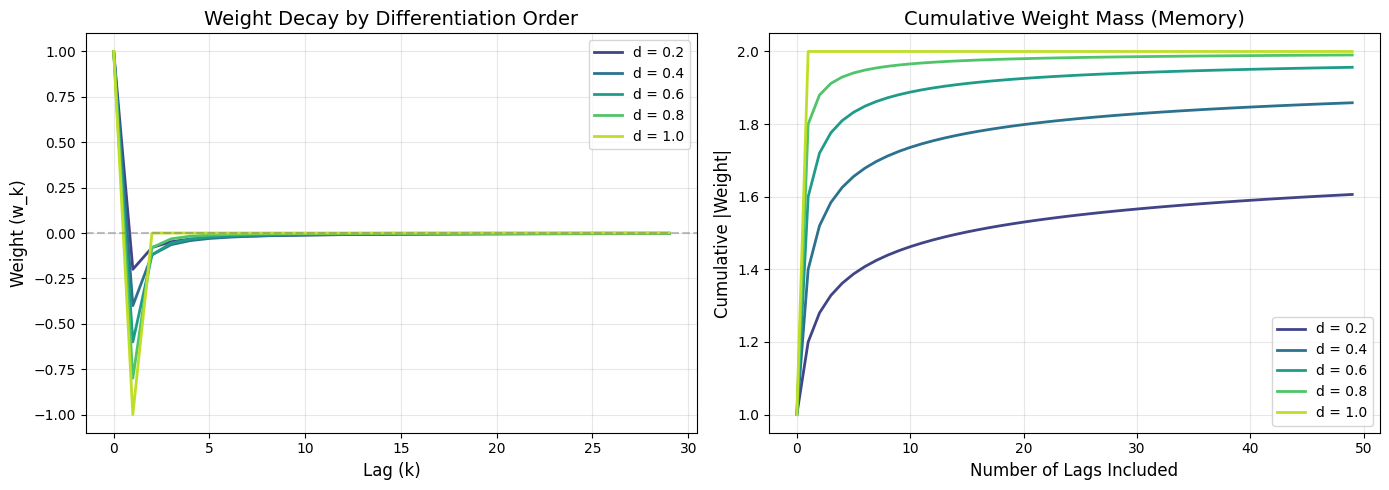


Key Observations:
- d=1.0: Only 2 non-zero weights (standard differencing)
- d<1.0: Weights decay slowly, preserving more memory
- Smaller d = slower decay = more historical information retained


In [2]:
# Visualize weight decay for different d values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Weight values over lags
d_values = [0.2, 0.4, 0.6, 0.8, 1.0]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(d_values)))

for d, color in zip(d_values, colors):
    weights = get_weight_convergence(d, num_lags=30)
    axes[0].plot(weights, label=f'd = {d}', color=color, linewidth=2)

axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Lag (k)', fontsize=12)
axes[0].set_ylabel('Weight (w_k)', fontsize=12)
axes[0].set_title('Weight Decay by Differentiation Order', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Cumulative absolute weight (shows memory)
for d, color in zip(d_values, colors):
    weights = get_weight_convergence(d, num_lags=50)
    cumsum = np.cumsum(np.abs(weights))
    axes[1].plot(cumsum, label=f'd = {d}', color=color, linewidth=2)

axes[1].set_xlabel('Number of Lags Included', fontsize=12)
axes[1].set_ylabel('Cumulative |Weight|', fontsize=12)
axes[1].set_title('Cumulative Weight Mass (Memory)', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- d=1.0: Only 2 non-zero weights (standard differencing)")
print("- d<1.0: Weights decay slowly, preserving more memory")
print("- Smaller d = slower decay = more historical information retained")

### Weight Interpretation

The weights tell us how much each past observation contributes to the fractionally differentiated value:

- **$w_0 = 1$**: Current observation always has weight 1
- **$w_1 = -d$**: First lag has weight $-d$
- **Subsequent weights**: Alternate in sign and decay in magnitude

For $d = 1$ (standard differencing):
- $w_0 = 1, w_1 = -1$, all others = 0
- Result: $\tilde{X}_t = X_t - X_{t-1}$ (simple return)

For $d = 0.5$:
- Weights extend much further into the past
- Result includes information from many prior observations

In [3]:
# Compare window sizes for different d values
print("FFD Window Sizes (threshold = 1e-4):")
print("-" * 40)
for d in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    window = len(compute_weights_ffd(d, weight_threshold=1e-4))
    print(f"d = {d:.1f}: {window:4d} weights")

print("\nSmaller d requires more weights (larger window) to capture the slow decay.")

FFD Window Sizes (threshold = 1e-4):
----------------------------------------
d = 0.2:  497 weights
d = 0.3:  388 weights
d = 0.4:  282 weights
d = 0.5:  200 weights
d = 0.6:  140 weights
d = 0.7:   97 weights
d = 0.8:   64 weights
d = 0.9:   38 weights
d = 1.0:    2 weights

Smaller d requires more weights (larger window) to capture the slow decay.


## 2. The Fixed-Width Window (FFD) Method

### Why FFD?

The theoretical formulation uses an **expanding window** - each observation uses all available history. This has problems:

1. **Computational cost**: Grows with series length
2. **Non-uniform memory**: Early observations use short windows, late observations use long windows
3. **Look-ahead bias**: Window size determined after seeing all data

### The FFD Solution

The **Fixed-width window Fractional Differentiation (FFD)** method truncates weights below a threshold:

$$\tilde{X}_t = \sum_{k=0}^{L} w_k X_{t-k} \quad \text{where } |w_k| \geq \tau$$

Benefits:
- **Constant window size** for all observations
- **O(1) computation** per observation
- **No look-ahead bias**

In [4]:
# Generate a synthetic price series (random walk with drift)
n_obs = 2000
daily_returns = np.random.randn(n_obs) * 0.02  # 2% daily volatility
drift = 0.0005  # Small positive drift
log_prices = 100 + np.cumsum(daily_returns + drift)
prices = pd.Series(
    np.exp(log_prices / 100) * 100,
    index=pd.date_range('2018-01-01', periods=n_obs, freq='D'),
    name='price'
)

print(f"Generated price series: {len(prices)} observations")
print(f"Date range: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Price range: ${prices.min():.2f} to ${prices.max():.2f}")

Generated price series: 2000 observations
Date range: 2018-01-01 to 2023-06-23
Price range: $271.24 to $279.65


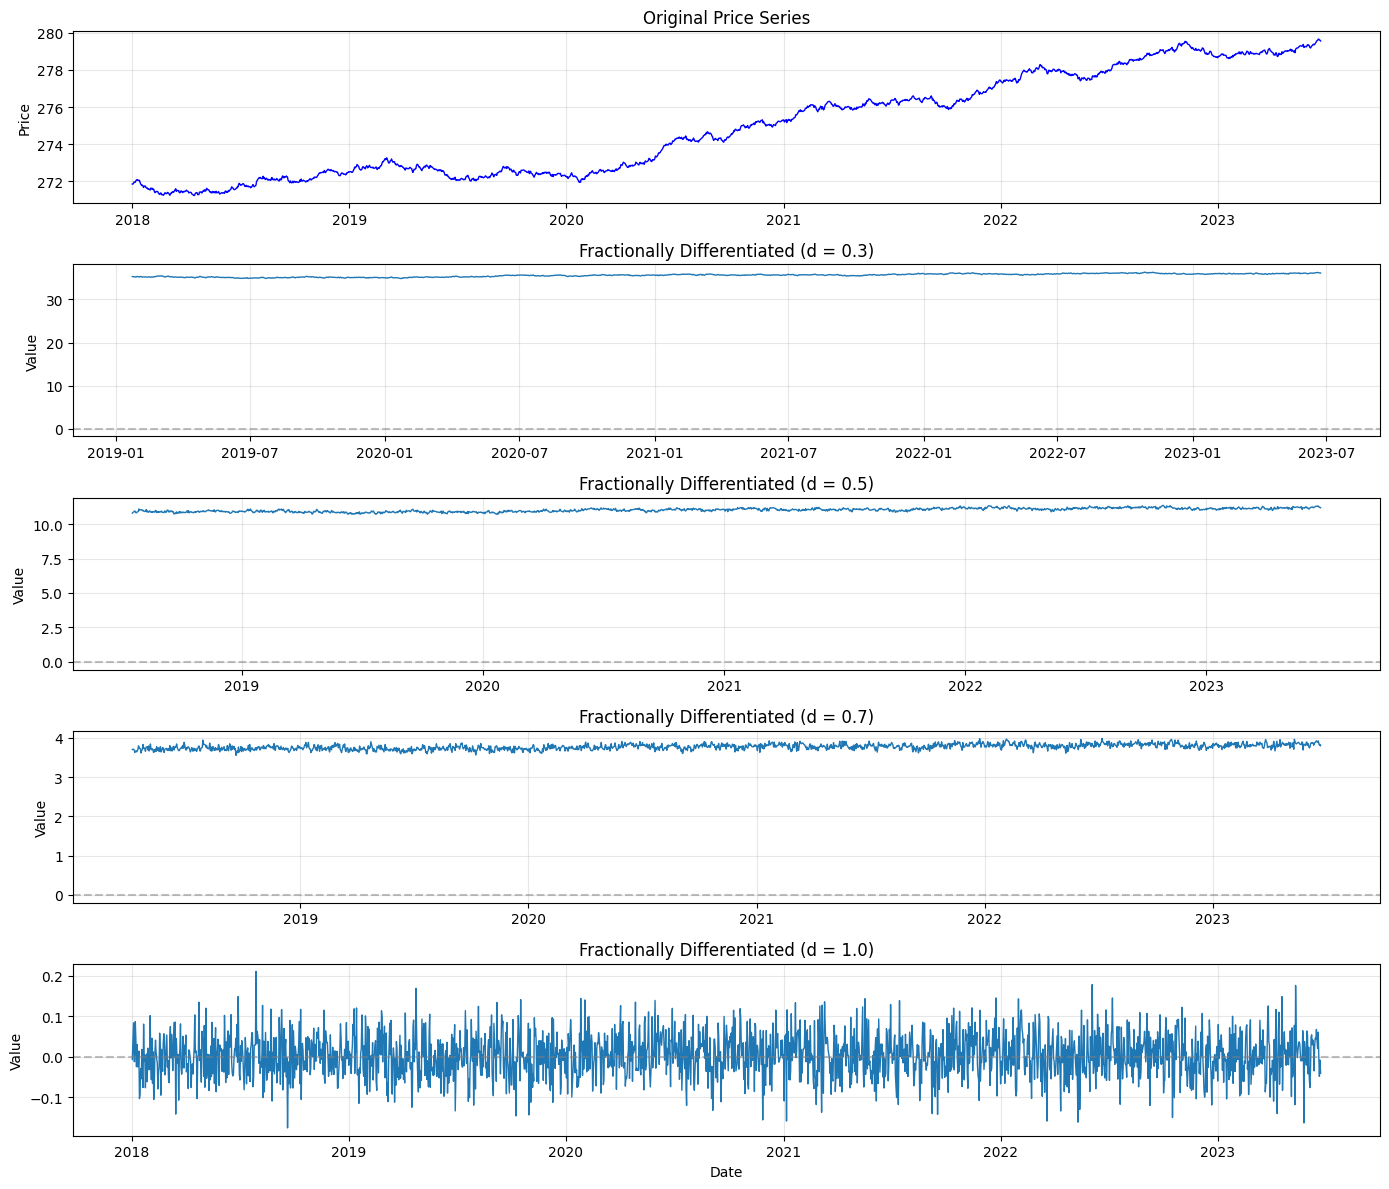


Observations:
- d=1.0 (returns): Oscillates around zero, appears stationary
- d=0.7: Similar to returns but with some trend memory
- d=0.5: More visible trending behavior
- d=0.3: Retains significant price-level information


In [5]:
# Apply fractional differentiation with different d values
d_values = [0.3, 0.5, 0.7, 1.0]

fig, axes = plt.subplots(len(d_values) + 1, 1, figsize=(14, 12))

# Plot original prices
axes[0].plot(prices.index, prices.values, 'b-', linewidth=1)
axes[0].set_title('Original Price Series', fontsize=12)
axes[0].set_ylabel('Price')
axes[0].grid(True, alpha=0.3)

# Plot fractionally differentiated series
for i, d in enumerate(d_values):
    fd = fracdiff_ffd(prices, diff_order=d, weight_threshold=1e-4)
    axes[i+1].plot(fd.index, fd.values, linewidth=1)
    axes[i+1].set_title(f'Fractionally Differentiated (d = {d})', fontsize=12)
    axes[i+1].set_ylabel('Value')
    axes[i+1].grid(True, alpha=0.3)
    axes[i+1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- d=1.0 (returns): Oscillates around zero, appears stationary")
print("- d=0.7: Similar to returns but with some trend memory")
print("- d=0.5: More visible trending behavior")
print("- d=0.3: Retains significant price-level information")

## 3. Testing for Stationarity: The ADF Test

### Augmented Dickey-Fuller Test

The **ADF test** checks whether a series has a **unit root** (non-stationary).

- **Null hypothesis ($H_0$)**: Series has a unit root (non-stationary)
- **Alternative ($H_1$)**: Series is stationary

**Interpretation:**
- p-value < 0.05: Reject $H_0$ → Series is stationary
- p-value > 0.05: Cannot reject $H_0$ → Series may be non-stationary

In [6]:
# Test stationarity of original prices vs returns
print("ADF Test Results")
print("=" * 60)

# Original prices
result = adf_test(prices)
print(f"\nOriginal Prices:")
print(f"  ADF Statistic: {result['adf_statistic']:.4f}")
print(f"  p-value: {result['p_value']:.4f}")
print(f"  Stationary: {'Yes' if result['is_stationary'] else 'No'}")

# Returns (d=1)
returns = prices.pct_change().dropna()
result = adf_test(returns)
print(f"\nReturns (d=1):")
print(f"  ADF Statistic: {result['adf_statistic']:.4f}")
print(f"  p-value: {result['p_value']:.6f}")
print(f"  Stationary: {'Yes' if result['is_stationary'] else 'No'}")

# Fractional differencing with d=0.5
fd_05 = fracdiff_ffd(prices, diff_order=0.5, weight_threshold=1e-4)
result = adf_test(fd_05.iloc[:, 0])
print(f"\nFractional (d=0.5):")
print(f"  ADF Statistic: {result['adf_statistic']:.4f}")
print(f"  p-value: {result['p_value']:.4f}")
print(f"  Stationary: {'Yes' if result['is_stationary'] else 'No'}")

ADF Test Results

Original Prices:
  ADF Statistic: 0.4818
  p-value: 0.9843
  Stationary: No

Returns (d=1):
  ADF Statistic: -45.1121
  p-value: 0.000000
  Stationary: Yes



Fractional (d=0.5):
  ADF Statistic: -1.6876
  p-value: 0.4375
  Stationary: No


## 4. Finding the Minimum d

### The Goal

Find the **smallest d** that achieves stationarity:

$$d^* = \min \{ d : \text{ADF p-value} < 0.05 \}$$

This preserves **maximum memory** while making the series usable for ML.

### The Tradeoff Visualization

In [7]:
# Find minimum d and analyze the tradeoff
d_candidates = np.arange(0.0, 1.05, 0.05).tolist()

result = find_minimum_d(
    prices,
    d_values=d_candidates,
    weight_threshold=1e-4
)

print(f"Minimum d for stationarity: {result['min_d']}")
if result['correlation'] is not None:
    print(f"Correlation with original prices: {result['correlation']:.4f}")
    print(f"Memory preserved: {abs(result['correlation'])*100:.1f}%")

Minimum d for stationarity: 0.65
Correlation with original prices: 0.6444
Memory preserved: 64.4%


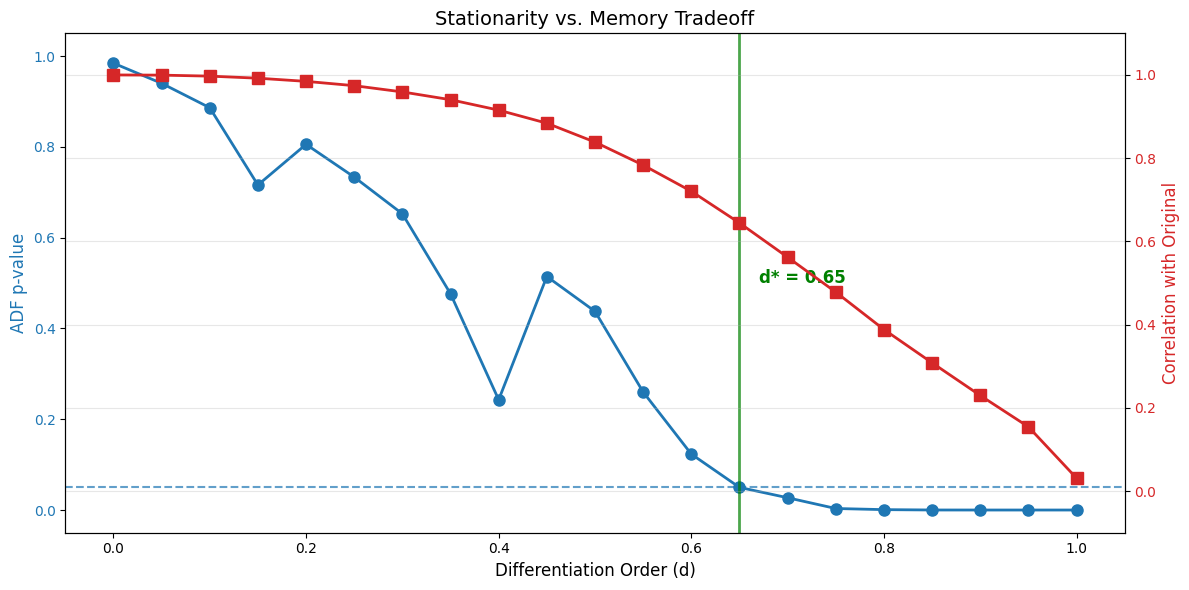


Interpretation:
- Blue line: ADF p-value (below 0.05 = stationary)
- Red line: Correlation with original (higher = more memory)
- Green line: Minimum d = 0.65 (optimal choice)


In [8]:
# Visualize the stationarity vs memory tradeoff
tradeoff = analyze_stationarity_memory_tradeoff(
    prices,
    d_values=d_candidates,
    weight_threshold=1e-4
)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot p-value (left axis)
color1 = 'tab:blue'
ax1.set_xlabel('Differentiation Order (d)', fontsize=12)
ax1.set_ylabel('ADF p-value', color=color1, fontsize=12)
ax1.plot(tradeoff['d'], tradeoff['p_value'], 'o-', color=color1, linewidth=2, markersize=8)
ax1.axhline(y=0.05, color=color1, linestyle='--', alpha=0.7, label='5% significance')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(-0.05, 1.05)

# Plot correlation (right axis)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Correlation with Original', color=color2, fontsize=12)
ax2.plot(tradeoff['d'], tradeoff['correlation'], 's-', color=color2, linewidth=2, markersize=8)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(-0.1, 1.1)

# Mark minimum d
if result['min_d'] is not None:
    ax1.axvline(x=result['min_d'], color='green', linestyle='-', linewidth=2, alpha=0.7)
    ax1.text(result['min_d'] + 0.02, 0.5, f"d* = {result['min_d']}", 
             fontsize=12, color='green', fontweight='bold')

plt.title('Stationarity vs. Memory Tradeoff', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Blue line: ADF p-value (below 0.05 = stationary)")
print("- Red line: Correlation with original (higher = more memory)")
print(f"- Green line: Minimum d = {result['min_d']} (optimal choice)")

## 5. Visual Comparison: The Impact of d

Let's see how different values of d affect the series properties.

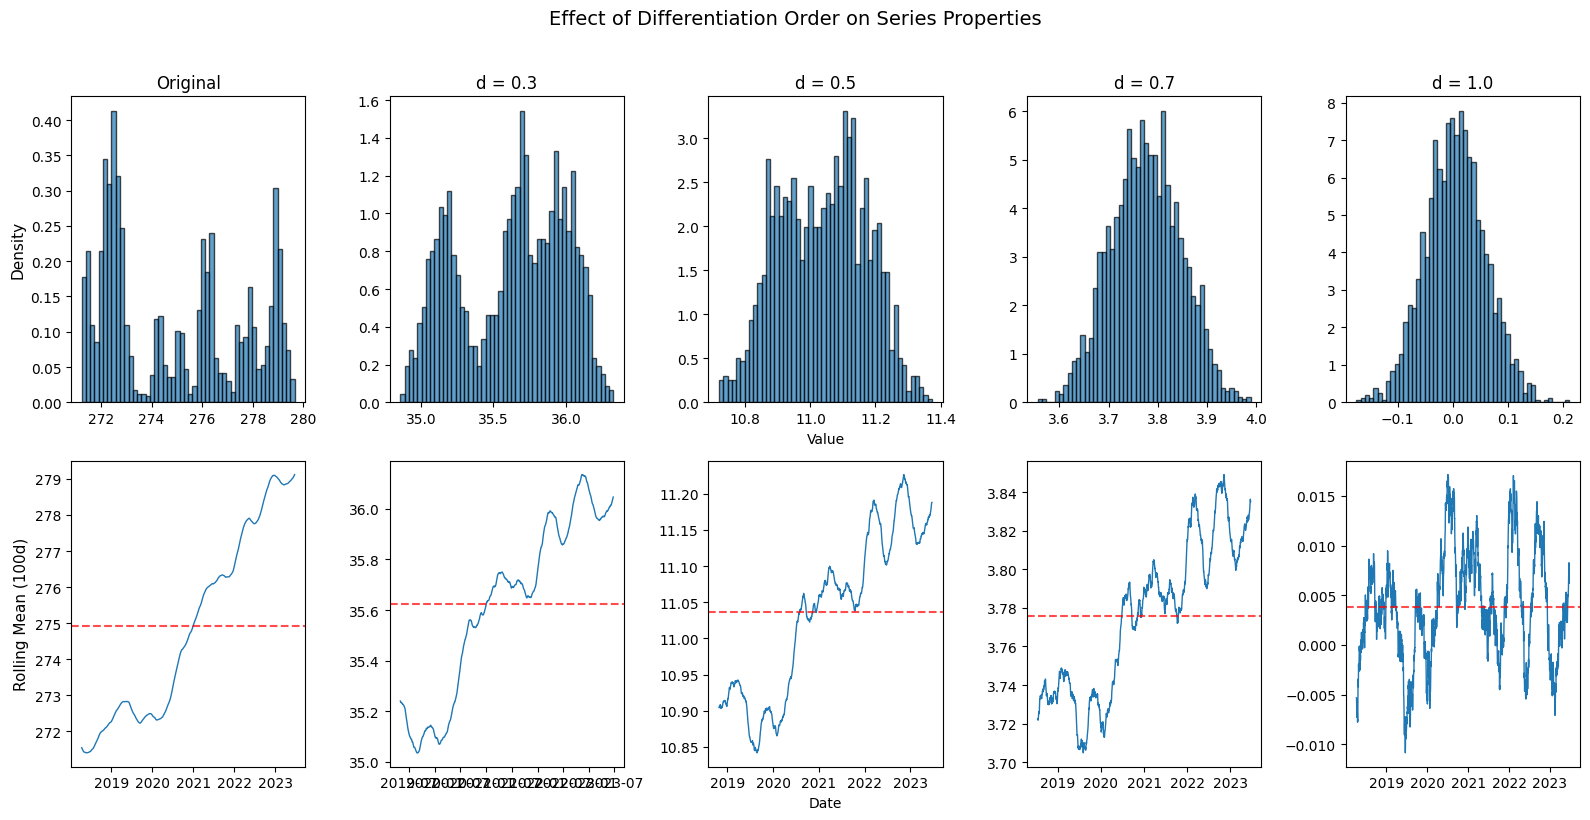

Top row: Distribution of values
  - Original prices: Spread out, not centered
  - Higher d: More concentrated around zero

Bottom row: Rolling mean (red line = global mean)
  - Stationary series: Rolling mean stays near global mean
  - Non-stationary: Rolling mean drifts over time


In [9]:
# Compare distributions and autocorrelations
from scipy import stats

d_compare = [0.0, 0.3, 0.5, 0.7, 1.0]

fig, axes = plt.subplots(2, len(d_compare), figsize=(16, 8))

for i, d in enumerate(d_compare):
    if d == 0:
        series = prices
        label = 'Original'
    else:
        series = fracdiff_ffd(prices, diff_order=d, weight_threshold=1e-4).iloc[:, 0]
        label = f'd = {d}'
    
    # Distribution (top row)
    axes[0, i].hist(series.dropna(), bins=50, density=True, alpha=0.7, edgecolor='black')
    axes[0, i].set_title(label, fontsize=12)
    if i == 0:
        axes[0, i].set_ylabel('Density', fontsize=11)
    
    # Rolling mean (bottom row) - shows stationarity
    rolling_mean = series.rolling(window=100).mean()
    axes[1, i].plot(rolling_mean.index, rolling_mean.values, linewidth=1)
    axes[1, i].axhline(y=series.mean(), color='red', linestyle='--', alpha=0.7)
    if i == 0:
        axes[1, i].set_ylabel('Rolling Mean (100d)', fontsize=11)

axes[0, 2].set_xlabel('Value')
axes[1, 2].set_xlabel('Date')

plt.suptitle('Effect of Differentiation Order on Series Properties', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("Top row: Distribution of values")
print("  - Original prices: Spread out, not centered")
print("  - Higher d: More concentrated around zero")
print("\nBottom row: Rolling mean (red line = global mean)")
print("  - Stationary series: Rolling mean stays near global mean")
print("  - Non-stationary: Rolling mean drifts over time")

## 6. Summary Statistics Comparison

In [10]:
# Summary statistics for different d values
summary_data = []

for d in [0.0, 0.3, 0.5, 0.7, 1.0]:
    if d == 0:
        series = prices
        name = 'Original'
    else:
        series = fracdiff_ffd(prices, diff_order=d, weight_threshold=1e-4).iloc[:, 0]
        name = f'd={d}'
    
    series_clean = series.dropna()
    
    # Compute correlation with original
    common_idx = prices.index.intersection(series_clean.index)
    corr = prices.loc[common_idx].corr(series_clean.loc[common_idx]) if len(common_idx) > 0 else np.nan
    
    # ADF test
    if len(series_clean) >= 20:
        adf_result = adf_test(series_clean)
        p_value = adf_result['p_value']
        is_stationary = adf_result['is_stationary']
    else:
        p_value = np.nan
        is_stationary = False
    
    summary_data.append({
        'Series': name,
        'Observations': len(series_clean),
        'Mean': series_clean.mean(),
        'Std': series_clean.std(),
        'ADF p-value': p_value,
        'Stationary': 'Yes' if is_stationary else 'No',
        'Corr w/ Orig': corr if d > 0 else 1.0
    })

summary_df = pd.DataFrame(summary_data)
print("Summary Statistics Comparison")
print("=" * 80)
print(summary_df.to_string(index=False))

Summary Statistics Comparison
  Series  Observations       Mean      Std  ADF p-value Stationary  Corr w/ Orig
Original          2000 274.915554 2.682661     0.984308         No      1.000000
   d=0.3          1613  35.622821 0.362668     0.652441         No      0.959203
   d=0.5          1801  11.036956 0.132662     0.437532         No      0.838649
   d=0.7          1904   3.775639 0.070758     0.027058        Yes      0.561977
   d=1.0          1999   0.003852 0.054368     0.000000        Yes      0.031043


## 7. Practical Workflow

### Step-by-Step Process

```
1. START with raw price series
         |
         v
2. TEST stationarity (ADF test)
         |
    Non-stationary? -----> Stationary? --> Use as-is
         |
         v
3. FIND minimum d
    - Test d = 0.0, 0.05, 0.10, ..., 1.0
    - Find smallest d with p-value < 0.05
         |
         v
4. APPLY FFD with d*
    - Use fixed-width window
    - Set threshold (e.g., 1e-4)
         |
         v
5. VERIFY
    - Check stationarity
    - Check correlation (memory preserved)
         |
         v
6. USE in ML model
```

In [11]:
# Complete practical example
print("Practical Workflow Example")
print("=" * 60)

# Step 1: Check original series
print("\n1. Original series stationarity:")
result = adf_test(prices)
print(f"   p-value = {result['p_value']:.4f} --> {'Stationary' if result['is_stationary'] else 'NOT Stationary'}")

# Step 2: Find minimum d
print("\n2. Finding minimum d for stationarity...")
min_d_result = find_minimum_d(prices, weight_threshold=1e-4)
d_star = min_d_result['min_d']
print(f"   Minimum d = {d_star}")

# Step 3: Apply FFD
print(f"\n3. Applying FFD with d = {d_star}...")
fd_optimal = fracdiff_ffd(prices, diff_order=d_star, weight_threshold=1e-4)
print(f"   Output length: {len(fd_optimal)} observations")

# Step 4: Verify results
print("\n4. Verification:")
result = adf_test(fd_optimal.iloc[:, 0])
print(f"   Stationarity: p-value = {result['p_value']:.6f} --> {'Stationary' if result['is_stationary'] else 'NOT Stationary'}")

common_idx = prices.index.intersection(fd_optimal.index)
correlation = prices.loc[common_idx].corr(fd_optimal.iloc[:, 0].loc[common_idx])
print(f"   Memory preserved: {abs(correlation)*100:.1f}% correlation with original")

# Step 5: Compare with standard returns
print("\n5. Comparison with standard returns (d=1):")
returns = prices.pct_change().dropna()
common_idx_ret = prices.index.intersection(returns.index)
corr_returns = prices.loc[common_idx_ret].corr(returns.loc[common_idx_ret])
print(f"   Returns memory: {abs(corr_returns)*100:.1f}% correlation with original")
print(f"   FFD advantage: {abs(correlation) - abs(corr_returns):.1%} more memory preserved")

Practical Workflow Example

1. Original series stationarity:
   p-value = 0.9843 --> NOT Stationary

2. Finding minimum d for stationarity...


   Minimum d = 0.65

3. Applying FFD with d = 0.65...


   Output length: 1884 observations

4. Verification:
   Stationarity: p-value = 0.049862 --> Stationary
   Memory preserved: 64.4% correlation with original

5. Comparison with standard returns (d=1):
   Returns memory: 3.1% correlation with original
   FFD advantage: 61.4% more memory preserved


## 8. Key Takeaways

### The Stationarity-Memory Dilemma

| Approach | Stationary? | Memory | ML Suitability |
|----------|-------------|--------|----------------|
| Raw prices | No | 100% | Poor |
| Returns (d=1) | Yes | ~0% | Limited |
| **FFD (d=d*)** | **Yes** | **Moderate** | **Best** |

### When to Use Fractional Differentiation

**Use FFD when:**
- Standard returns lose too much predictive signal
- You suspect long-memory effects are important
- Your ML model performs poorly with simple returns

**Parameters to tune:**
- **d**: Start with `find_minimum_d()` result, adjust if needed
- **threshold**: 1e-4 to 1e-5 typical (lower = more memory, larger window)

### Implementation Tips

1. **Always use FFD** (not expanding window) for production
2. **Verify stationarity** after applying FFD
3. **Check window size** - ensure you have enough history
4. **Monitor correlation** - ensure meaningful memory is preserved
5. **Re-estimate d*** periodically as market dynamics change

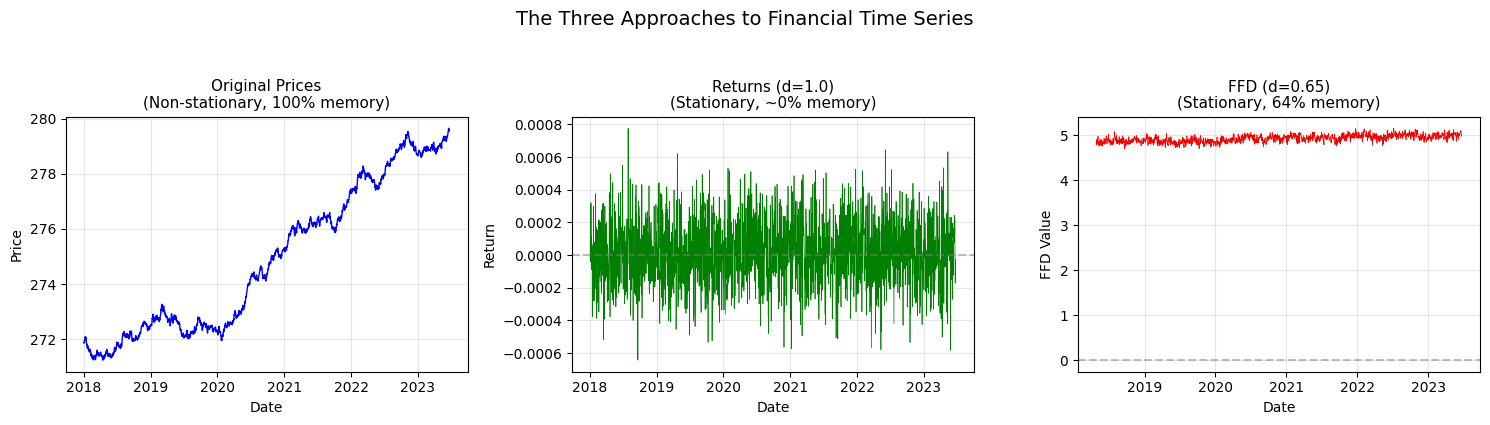


Conclusion:
FFD with d=0.65 achieves stationarity while preserving 64% of the original memory.
This is the 'best of both worlds' - usable for ML while retaining predictive signal.


In [12]:
# Final summary visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get optimal FFD series
fd_optimal = fracdiff_ffd(prices, diff_order=d_star, weight_threshold=1e-4)
returns = prices.pct_change().dropna()

# Plot 1: Original prices
axes[0].plot(prices.index, prices.values, 'b-', linewidth=1)
axes[0].set_title(f'Original Prices\n(Non-stationary, 100% memory)', fontsize=11)
axes[0].set_ylabel('Price')
axes[0].grid(True, alpha=0.3)

# Plot 2: Standard returns
axes[1].plot(returns.index, returns.values, 'g-', linewidth=0.5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title(f'Returns (d=1.0)\n(Stationary, ~0% memory)', fontsize=11)
axes[1].set_ylabel('Return')
axes[1].grid(True, alpha=0.3)

# Plot 3: Optimal FFD
axes[2].plot(fd_optimal.index, fd_optimal.values, 'r-', linewidth=0.5)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title(f'FFD (d={d_star})\n(Stationary, {abs(correlation)*100:.0f}% memory)', fontsize=11)
axes[2].set_ylabel('FFD Value')
axes[2].grid(True, alpha=0.3)

for ax in axes:
    ax.set_xlabel('Date')

plt.suptitle('The Three Approaches to Financial Time Series', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("\nConclusion:")
print(f"FFD with d={d_star} achieves stationarity while preserving {abs(correlation)*100:.0f}% of the original memory.")
print("This is the 'best of both worlds' - usable for ML while retaining predictive signal.")